# Libraries utilized

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold, LeaveOneOut
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lars, HuberRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random as r


r.seed(1)

# Plotting (With Outliers & Without Outliers)

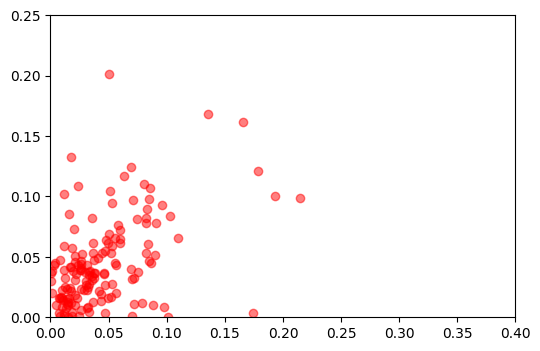

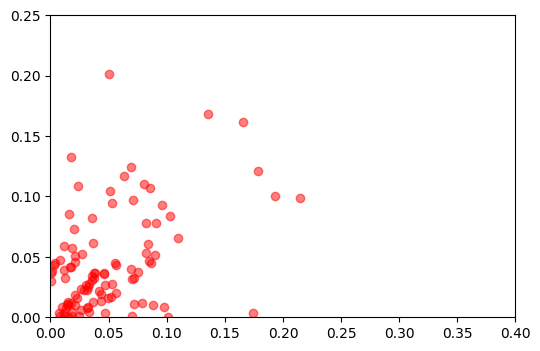

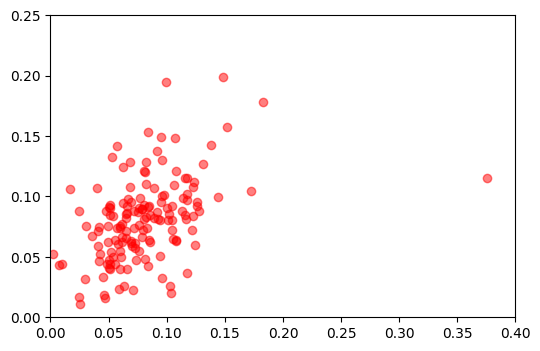

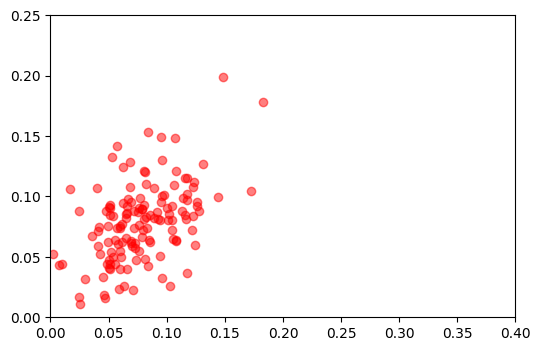

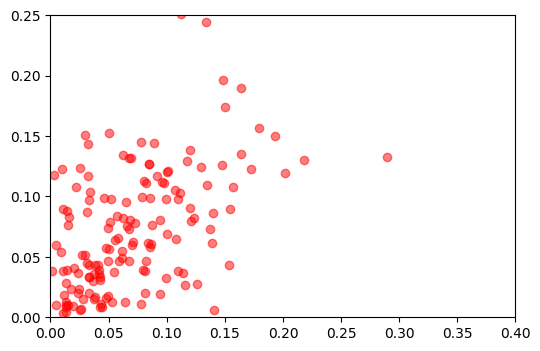

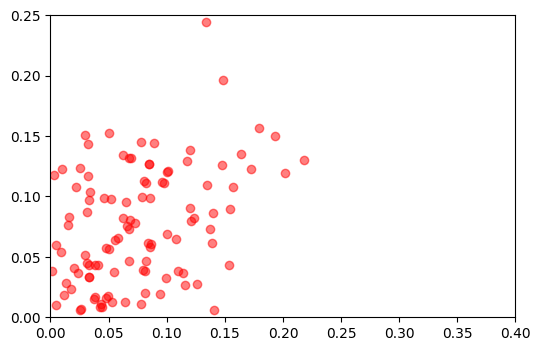

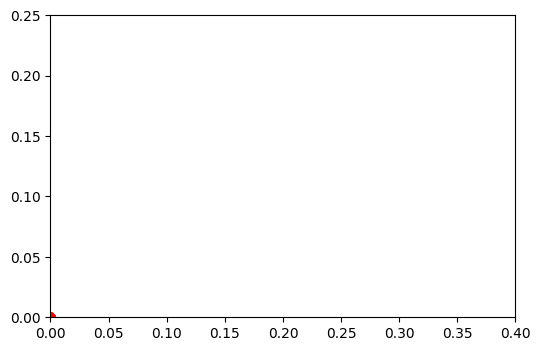

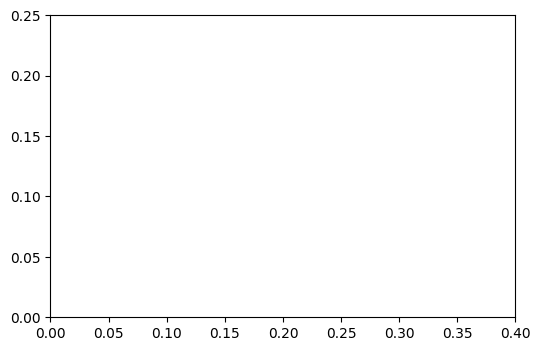

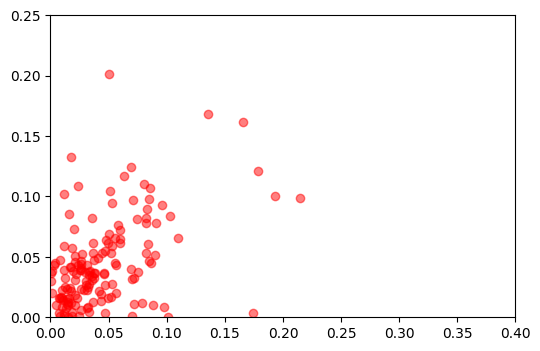

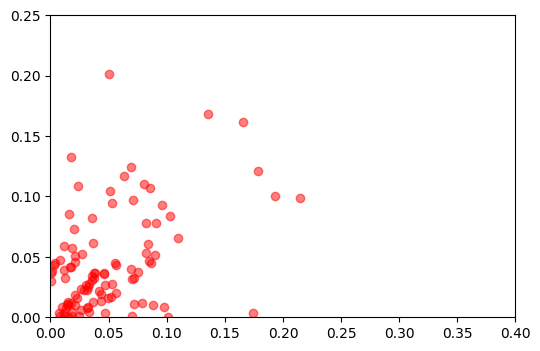

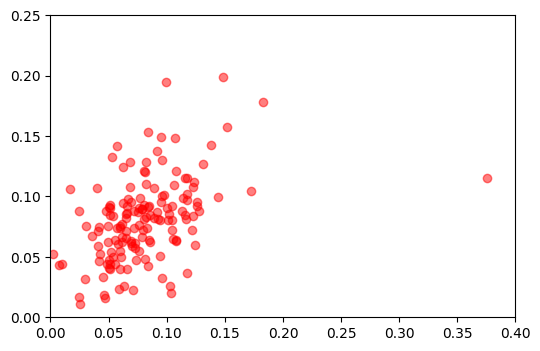

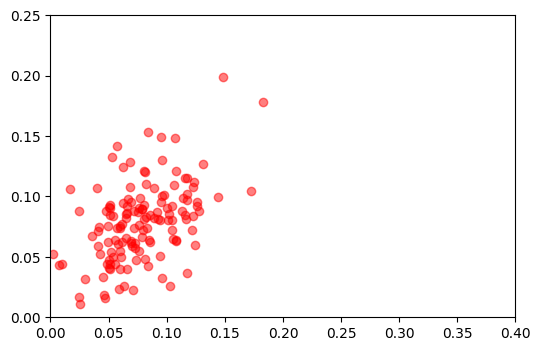

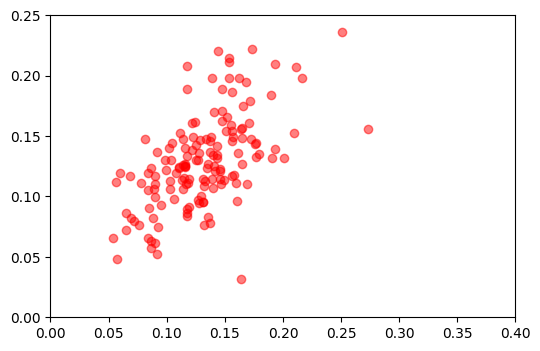

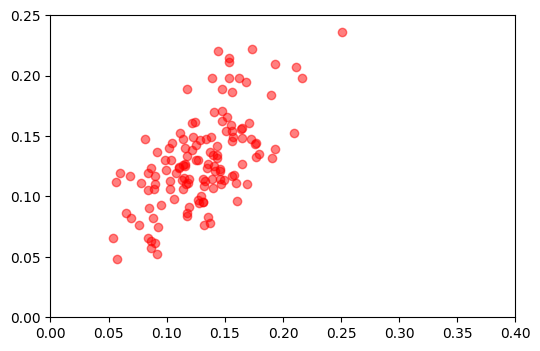

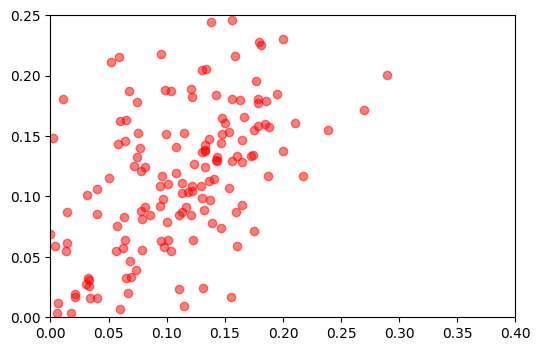

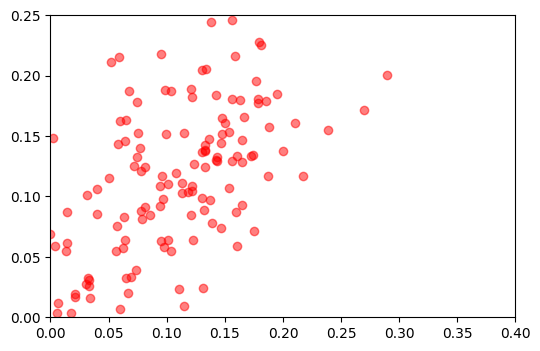

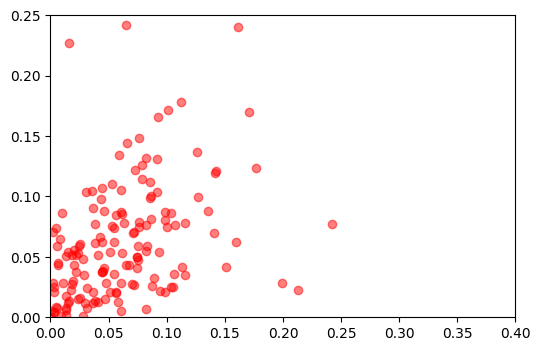

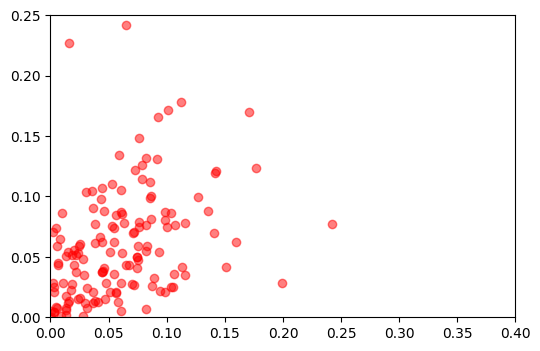

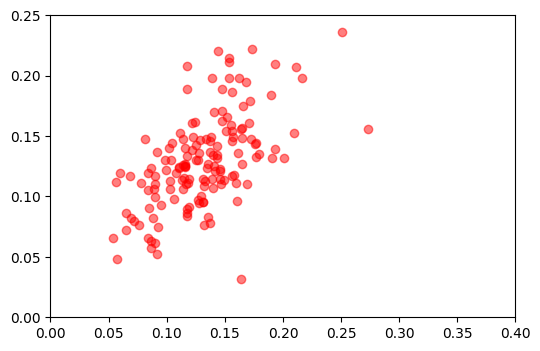

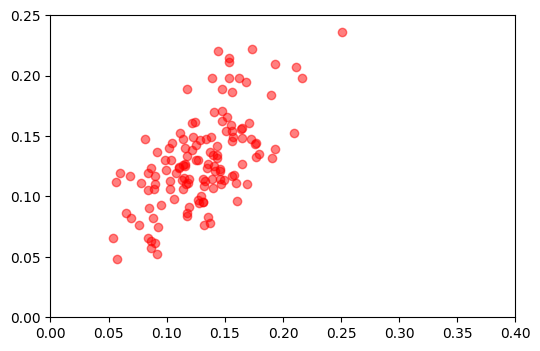

In [17]:
N_FEATURES = 595

train_t0 = pd.read_csv("train_t0.csv").values[:, 1:]
train_t1 = pd.read_csv("train_t1.csv").values[:, 1:]
test_t0 = pd.read_csv("test_t0.csv").values[:, 1:]
x = np.arange(0, 150)
for i in range(10):
	plt.figure(dpi=100)
	plt.autoscale(False)
	plt.xlim(0, 0.4)
	plt.ylim(0, 0.25)
	x = train_t0[:, i]
	y = train_t1[:, i]
	plt.scatter(x, y, color="red", alpha=0.5)
	plt.show()
	plt.figure(dpi=100)
	plt.autoscale(False)
	plt.xlim(0, 0.4)
	plt.ylim(0, 0.25)
	diff = train_t0[:, i] - train_t1[:, i]
	outlier_detector = OneClassSVM(kernel = "rbf", nu = 0.04, tol=1e-4)
	to_fit = np.array([diff]).T
	predicts = outlier_detector.fit_predict(to_fit)
	non_outliers = predicts != -1
	x = x[non_outliers]
	y = y[non_outliers]
	plt.scatter(x, y, color="red", alpha=0.5)
	plt.show()

# The Submitted Code

## Loading The Data

In [28]:
N_FEATURES = 595

train_t0 = pd.read_csv("train_t0.csv").values[:, 1:]
train_t1 = pd.read_csv("train_t1.csv").values[:, 1:]
test_t0 = pd.read_csv("test_t0.csv").values[:, 1:]

## LOO Method For Removing Outliers (not used for the final model)

In [29]:
#LOO method for removing outliers
#Implemented but not used for the final score
def remove_outliers(train_t0, train_t1, n_outliers): #removes n outliers from the given dataset
    loo = LeaveOneOut()
    loo.get_n_splits(train_t0)
    #MSEs of each sample in the i-th feature if it is excluded from training
    errors = [[] for i in range(N_FEATURES)]
    cur_split = 1
    #LOO CV begins
    for train_index, test_index in loo.split(train_t0):
        t0_train, t0_test = train_t0[train_index], train_t0[test_index]
        t1_train, t1_test = train_t1[train_index], train_t1[test_index]
        #training each feature individually
        for feature_index in range(N_FEATURES):
            train_t0_samples = t0_train[:, feature_index]
            train_t0_samples = np.array([train_t0_samples]).T # to make it suitable for regressor.fit
            train_t1_samples = t1_train[:, feature_index]
            #using linear regression as the regressor
            regressor = LinearRegression()
            regressor.fit(train_t0_samples, train_t1_samples)
            #predicting the test samples
            test_t0_sample = t0_test[:, feature_index]
            predicted_value = regressor.predict([test_t0_sample])[0]
            ground_truth = t1_test[:, feature_index][0]
            #we considered the error as the absolute difference between the ground truth and prediction
            errors[feature_index].append([test_index[0], np.abs(ground_truth - predicted_value)])
        print("%d-th split in LOO in remove_outliers function" % cur_split)
        cur_split += 1
    #LOO CV ends
    #Now, removing the outliers from each feature
    for feature_index in range(N_FEATURES):
        errors[feature_index].sort(key = lambda x: -x[1]) #sorts the errors in ascending order
        to_be_removed = errors[feature_index][:n_outliers] #indices of the removed outliers
        for [index, error] in to_be_removed:
            train_t0[index][feature_index] = -1 #this cell will not be used since it is an outlier

    #transposing the dataset
    train_t0 = train_t0.T
    train_t1 = train_t1.T
    #now, outliers will be deleted from the columns (features)
    #we took the transpose because we wanted the columns to be shifted, not the rows so that features do not get mixed
    new_train_t0 = []
    new_train_t1 = []
    for feature_index in range(N_FEATURES):
        outlier_index = np.where(train_t0[feature_index] == -1)
        new_row_t0 = np.delete(train_t0[feature_index], outlier_index, 0)
        new_row_t1 = np.delete(train_t1[feature_index], outlier_index, 0)
        new_train_t0.append(new_row_t0)
        new_train_t1.append(new_row_t1)
    #retransposing them again to their original forms
    train_t0 = np.array(new_train_t0)
    train_t1 = np.array(new_train_t1)
    train_t0 = train_t0.T
    train_t1 = train_t1.T
    return train_t0, train_t1

## 5-Fold CV Implementation

In [30]:
def FiveFoldCV(train_t0, train_t1, SVM_kernel="rbf", SVM_nu=0.04, SVM_tol=1e-4,
                LR_fit_intercept=True, SGD_loss="huber", SGD_tol=1e-4, Ridge_tol=1e-4):
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    kf.get_n_splits(train_t0)
    cur_split = 0
    #5-Fold CV begins
    for train_index, test_index in kf.split(train_t0):
        t0_train, t0_test = train_t0[train_index], train_t0[test_index]
        t1_train, t1_test = train_t1[train_index], train_t1[test_index]
        pred_list = []
        #training and testing each feature individually
        for feature_index in range(N_FEATURES):
            train_t0_samples = t0_train[:, feature_index]
            train_t1_samples = t1_train[:, feature_index]
            train_t0_samples = np.array([train_t0_samples]).T # to make it suitable for regressor.fit
            #applying OneClassSVM on the dataset to remove the outliers
            one_class_svm = True
            if one_class_svm and train_t0_samples[0][0] != 0:
                outlier_detector = OneClassSVM(kernel = SVM_kernel, nu = SVM_nu, tol=SVM_tol)
                to_fit = np.abs(train_t0_samples - np.array([train_t1_samples]).T)
                predicts = outlier_detector.fit_predict(to_fit)
                non_outliers = predicts != -1
                train_t0_samples = train_t0_samples[non_outliers]
                train_t1_samples = train_t1_samples[non_outliers]
            #applying QuantileTransformer to scale the data
            sc = QuantileTransformer(n_quantiles=len(train_t0_samples))
            train_t0_samples = sc.fit_transform(train_t0_samples)
            #the selected estimators
            estimators = [
                ('e1', LinearRegression(fit_intercept=LR_fit_intercept)),
                ('e2', Lars()),
                ('e3', SGDRegressor(loss=SGD_loss, tol=SGD_tol)),
                ('e4', Ridge(tol=Ridge_tol)),
                ('e5', HuberRegressor())
            ]
            #training the VotingRegressor
            regressor = VotingRegressor(estimators=estimators)
            regressor.fit(train_t0_samples, train_t1_samples)
            #testing the model with test samples
            test_t0_samples = t0_test[:, feature_index]
            test_t0_samples = np.array([test_t0_samples]).T
            test_t0_samples = sc.transform(test_t0_samples)
            predicted_values = regressor.predict(test_t0_samples)
            pred_list.append(predicted_values)
        pred_list = np.array(pred_list).T
        print("MSE for the %d-th split:" % cur_split, mean_squared_error(t1_test, pred_list))
        print("MAD for the %d-th split:" % cur_split, mean_absolute_error(t1_test, pred_list))
        cur_split += 1

## Running 5-Fold CV to Observe The Results

In [27]:
FiveFoldCV(train_t0, train_t1)

MSE for the 0-th split: 0.00371384304485397
MAD for the 0-th split: 0.03512147539344078
MSE for the 1-th split: 0.004437709872405278
MAD for the 1-th split: 0.03890197250376263
MSE for the 2-th split: 0.0019269462930804732
MAD for the 2-th split: 0.031339245311355984
MSE for the 3-th split: 0.003283065181671125
MAD for the 3-th split: 0.03634879591163752
MSE for the 4-th split: 0.0062261169769127584
MAD for the 4-th split: 0.03796786951771208


## The Main Code to Generate Predictions For Kaggle Competition

In [31]:
#this part of the code is used for submitting predictions to Kaggle
pred_list = [] #stores all predictions
#training and testing each feature individually
for feature_index in range(N_FEATURES):
    train_t0_samples = train_t0[:, feature_index]
    train_t0_samples = np.array([train_t0_samples]).T
    train_t1_samples = train_t1[:, feature_index]
    #applying OneClassSVM to remove the outliers
    one_class_svm = True
    if one_class_svm and train_t0_samples[0][0] != 0:
        outlier_detector = OneClassSVM(kernel = "rbf", nu = 0.04, tol=1e-4)
        to_fit = np.abs(train_t0_samples - np.array([train_t1_samples]).T)
        predicts = outlier_detector.fit_predict(to_fit)
        non_outliers = predicts != -1
        train_t0_samples = train_t0_samples[non_outliers]
        train_t1_samples = train_t1_samples[non_outliers]
    #applying the QuantileTransformer to scale the data
    sc = QuantileTransformer(n_quantiles=len(train_t0_samples))
    train_t0_samples = sc.fit_transform(train_t0_samples)
    #the selected estimators
    estimators = [
        ('e1', LinearRegression(fit_intercept=True)),
        ('e2', Lars()),
        ('e3', SGDRegressor(loss="huber", tol=1e-4)),
        ('e4', Ridge(tol=1e-4)),
        ('e5', HuberRegressor())
    ]
    #training the VotingRegressor
    regressor = VotingRegressor(estimators=estimators)
    regressor.fit(train_t0_samples, train_t1_samples)
    #testing the model with test samples
    test_t0_samples = test_t0[:, feature_index]
    test_t0_samples = np.array([test_t0_samples]).T
    test_t0_samples = sc.transform(test_t0_samples)
    predicted = regressor.predict(test_t0_samples)
    pred_list.append(predicted)

pred_list = np.array(pred_list).T
pred_list = pred_list.flatten()
ids = np.arange(0, 47600)
pd.DataFrame({"ID": ids, "predicted": pred_list}).to_csv("predictions.csv", index=False)